# 6.6 Analyzing Time Series Data

## Content
1. Import data and Libraries 
2. Data prep 
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing

I chose this data as it has the total counts of US births on each day of the year from 2000 - 2014 to identify genearl trends, and help make predictions. This will 'prove to be helpful with my overall analysis of births and education level. Link: https://data.world/fivethirtyeight/births

## Importing data and libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#importing data
path = r'C:\Users\tlayt\OneDrive\Documents\CF Data Analytics\Acheivement 6\Final Project'

In [3]:
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'US_births_2000-2014_SSA.csv'), index_col = False)

In [4]:
df.head()

,year,month,date_of_month,Date,day_of_week,births
0,2000,1,1,1/1/2000,6,9083
1,2000,1,2,1/2/2000,7,8006
2,2000,1,3,1/3/2000,1,11363
3,2000,1,4,1/4/2000,2,13032
4,2000,1,5,1/5/2000,3,12558


## Data Prep

In [5]:
# Check for missing values

df.isnull().sum()
#none!

year             0
month            0
date_of_month    0
Date             0
day_of_week      0
births           0
dtype: int64

In [6]:
# Check for duplicates

dups = df.duplicated()
dups.sum()

# No dups!

0

In [7]:
#creating new column of month + year to be able to groupby
df['MMYY']=pd.to_datetime(df.year.astype(str) + '/' + df.month.astype(str))

In [8]:
df.head()

,year,month,date_of_month,Date,day_of_week,births,MMYY
0,2000,1,1,1/1/2000,6,9083,2000-01-01
1,2000,1,2,1/2/2000,7,8006,2000-01-01
2,2000,1,3,1/3/2000,1,11363,2000-01-01
3,2000,1,4,1/4/2000,2,13032,2000-01-01
4,2000,1,5,1/5/2000,3,12558,2000-01-01


In [9]:
#group by year and month with sum of births 
df.groupby('MMYY')['births'].sum()

MMYY
2000-01-01    337739
2000-02-01    324046
2000-03-01    347824
2000-04-01    323357
2000-05-01    347950
               ...  
2014-08-01    356066
2014-09-01    350497
2014-10-01    344471
2014-11-01    318655
2014-12-01    339726
Name: births, Length: 180, dtype: int64

In [10]:
#crating new dataframe 
df1 = df.groupby('MMYY')['births'].sum().reset_index()

In [11]:
#checking
df1

,MMYY,births
0,2000-01-01,337739
1,2000-02-01,324046
2,2000-03-01,347824
3,2000-04-01,323357
4,2000-05-01,347950
...,...,...
175,2014-08-01,356066
176,2014-09-01,350497
177,2014-10-01,344471
178,2014-11-01,318655


In [12]:
df1.shape

(180, 2)

In [13]:
# Set the "MMYY" column as the index

from datetime import datetime

df1['datetime'] = pd.to_datetime(df1['MMYY']) 
df1 = df1.set_index('datetime') 
df1.drop(['MMYY'], axis=1, inplace=True) 
df1.head()

,births
datetime,
2000-01-01,337739
2000-02-01,324046
2000-03-01,347824
2000-04-01,323357
2000-05-01,347950


Text(0, 0.5, 'Birth Counts')

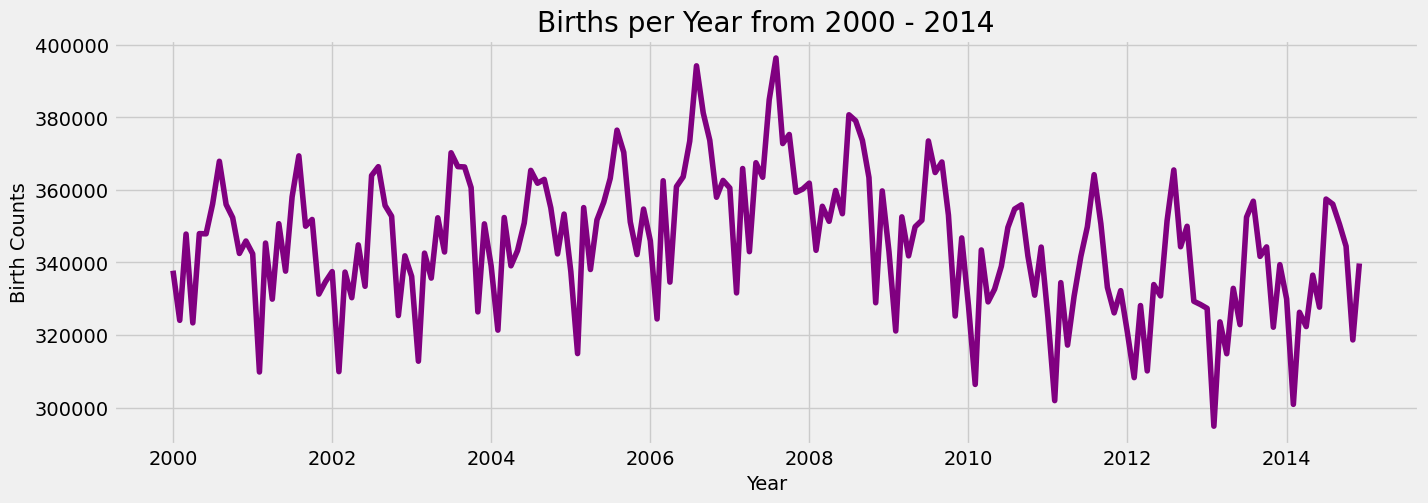

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df1, color='purple')
plt.title('Births per Year from 2000 - 2014')
plt.xlabel('Year')
plt.ylabel('Birth Counts')

## Time-Series Analysis:decomp

In [45]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df1, model='additive')

In [46]:
#define size of charts
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

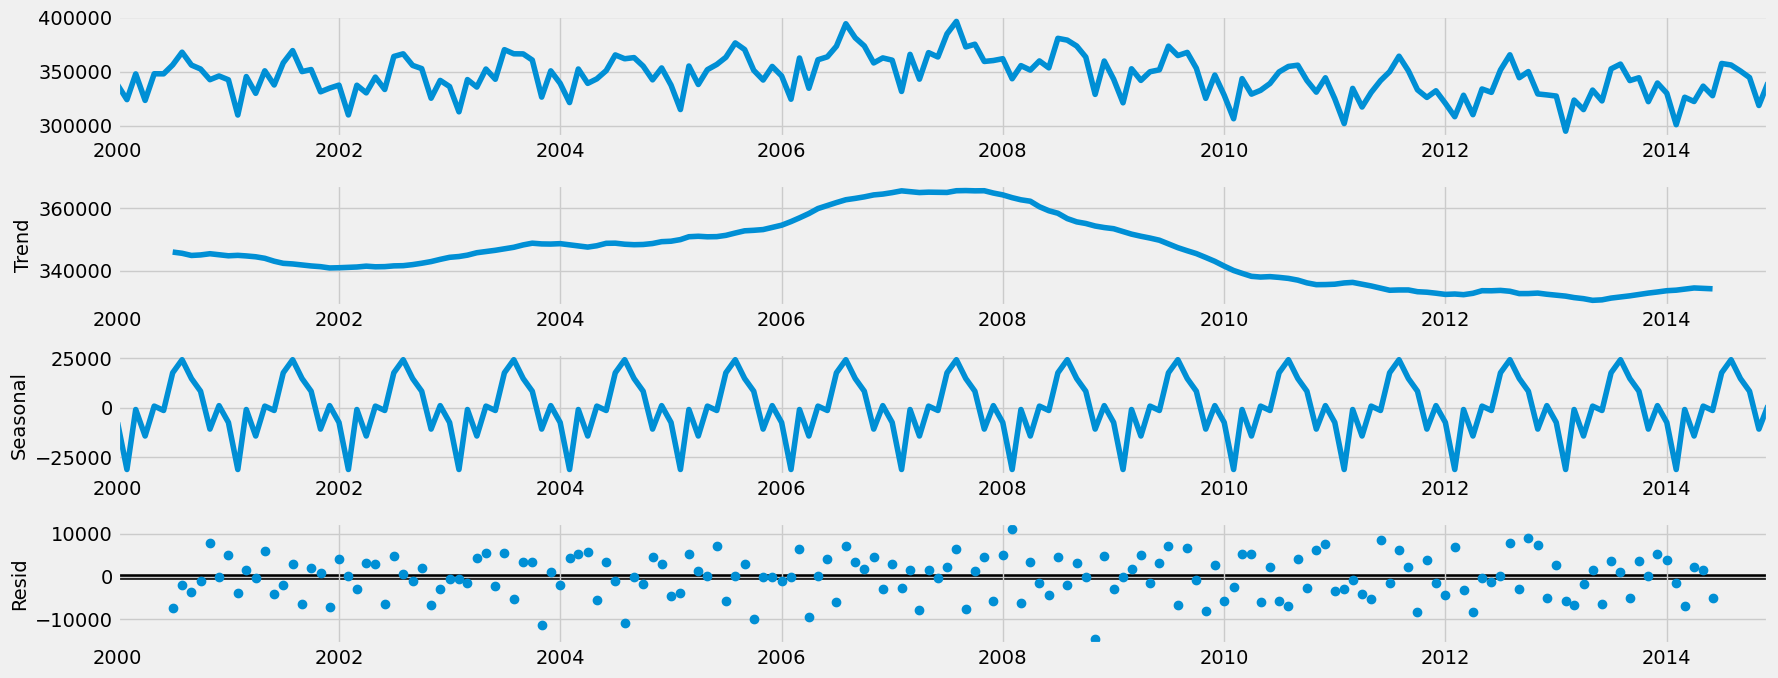

In [47]:
# Plot the separate components

decomposition.plot()
plt.show()

The general trend of this data looks like it goes up a bit till 2008 and then steadily declines till mid 2013 then may go up just a little bit again. This data certainly has a very distinct seasonality to it (low birth counts at the begining and end of the year and high birth counts mid year). It also has quite a bit of noise. The drop in birth counts in mid 2007 is likely due to the economic recession of 2008. This data seems to be, if not almost, stationary. 

## Testing for stationarity

Null: There is a unit root (meaning data is stationary).
Alternative: There is no unit root. 

In [49]:
#cunducting a dickey-fuller test 
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df1['births'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.246461
p-value                          0.653297
Number of Lags Used             14.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


I can not reject my null hypothesis due to the test statistic being greater than all the critical values. The p-value is also very high for a significance value.  
All of this indicating my data is not stationary. 

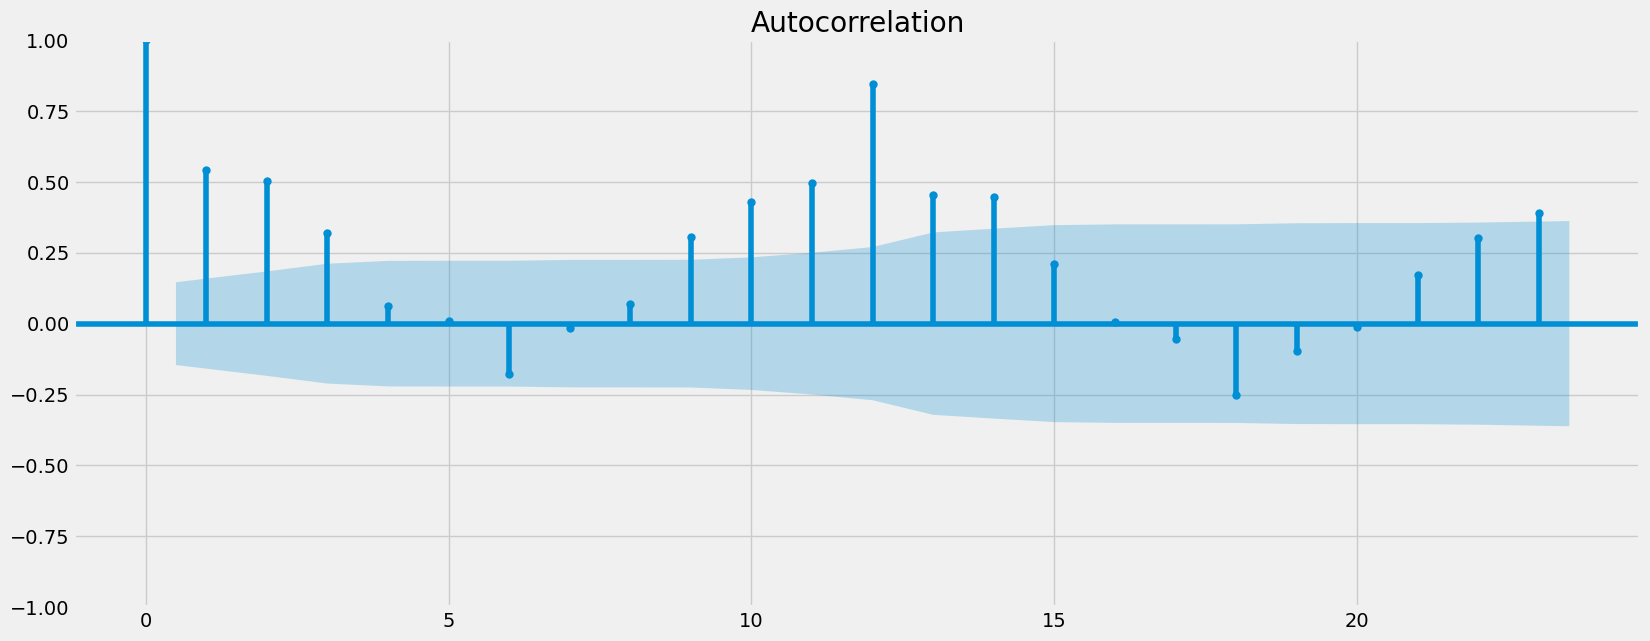

In [50]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(df1)
plt.show()

Additionally, looking at the autocorrelation, there are 10 lines above the blue edge of the confidence interval indicating the lags are correlated. 

## Stationarizing

In [51]:
#Setting up for differencing technique
data_diff = df1 - df1.shift(1) 

In [52]:
#removing missing values 
data_diff.dropna(inplace = True)

In [53]:
data_diff.head()

,births
datetime,
2000-02-01,-13693.0
2000-03-01,23778.0
2000-04-01,-24467.0
2000-05-01,24593.0
2000-06-01,-51.0


In [54]:
data_diff.columns

Index(['births'], dtype='object')

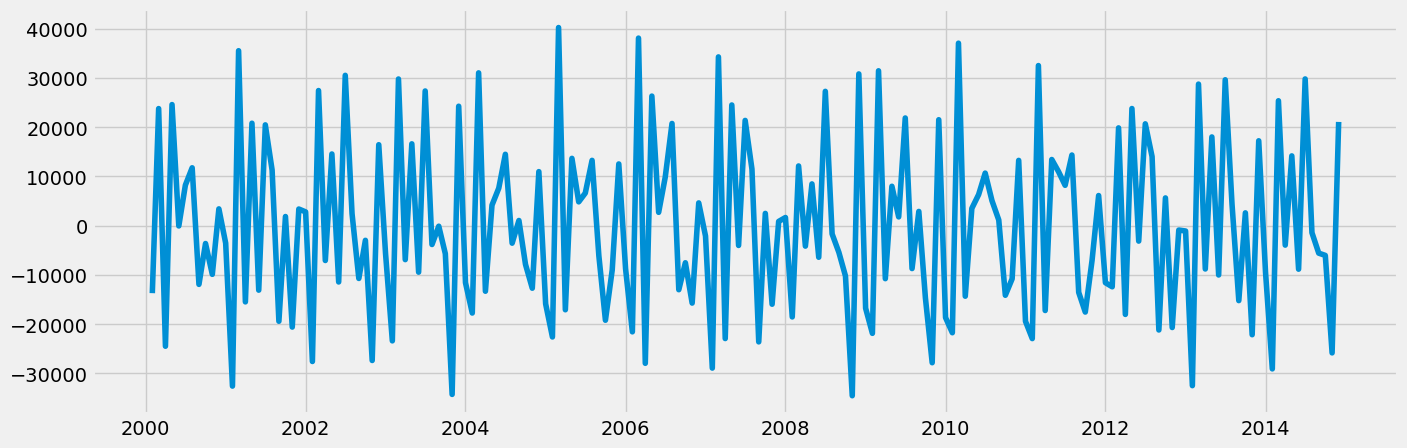

In [55]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [56]:
#redo Dickey Fuller 
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.862930
p-value                          0.049832
Number of Lags Used             13.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


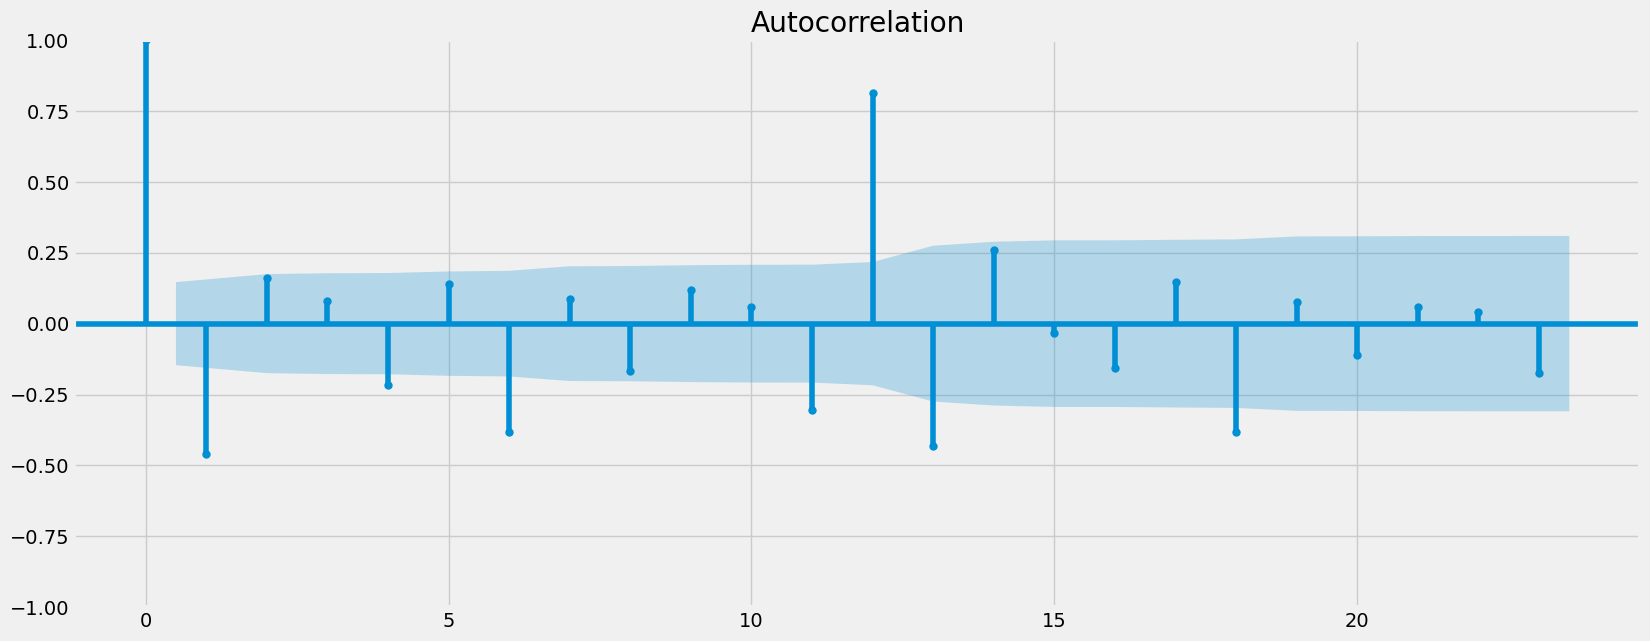

In [57]:
plot_acf(data_diff)
plt.show()

By redoing the dickey-fuller test we can see that the test stat is now less than the 10% significance level and we now have a satisfactory p-value whcih means we can reject the null hypothesis and our data is now stationary. 